In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy

In [4]:
#Construct an ImageDataGenerator object:
DIRECTORY = "Covid19-dataset/train"
CLASS_MODE = "categorical"
COLOR_MODE = "grayscale"
TARGET_SIZE = (256,256)
BATCH_SIZE = 32

training_data_generator = ImageDataGenerator(rescale=1.0/255,

#Randomly increase or decrease the size of the image by up to 10%
zoom_range=0.1, 

#Randomly rotate the image between -25,25 degrees
rotation_range=25, 

#Shift the image along its width by up to +/- 5%
width_shift_range=0.05, 

#Shift the image along its height by up to +/- 5%
height_shift_range=0.05,

)

validation_data_generator = ImageDataGenerator()

In [5]:
training_iterator = training_data_generator.flow_from_directory(DIRECTORY,class_mode='categorical',color_mode='grayscale',batch_size=BATCH_SIZE)#, subset='training')

training_iterator.next()

print("\nLoading validation data...")


validation_iterator = validation_data_generator.flow_from_directory(DIRECTORY,class_mode='categorical', color_mode='grayscale',batch_size=BATCH_SIZE)#, subset='validation')

Found 251 images belonging to 3 classes.



Loading validation data...
Found 251 images belonging to 3 classes.


In [6]:
#Print its attributes:
# print(training_data_generator.__dict__)


print("\nBuilding model...")

def design_model(training_data):
    # sequential model
    model = Sequential()
    # add input layer with grayscale image shape
    model.add(tf.keras.Input(shape=(256, 256, 1)))
    # convolutional hidden layers with relu functions
    # maxpooling layers and dropout layers as well
    model.add(layers.Conv2D(5, 5, strides=3, activation="relu")) 
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(3, 3, strides=1, activation="relu")) 
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.2))

    # experimenting with extra layesr
    #model.add(tf.keras.layers.Conv2D(3, 3, strides=1, activation="relu"))
    #model.add(tf.keras.layers.Conv2D(1, 1, strides=1, activation="relu"))
    #model.add(tf.keras.layers.Dropout(0.1))

    model.add(layers.Flatten())
    # output layer with softmax activation function
    model.add(layers.Dense(3,activation="softmax"))
    # compile model with Adam optimizer
    # loss function is categorical crossentropy
    # metrics are categorical accuracy and AUC
    print("\nCompiling model...")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()],)
    # summarize model
    model.summary()
    return model


Building model...


In [7]:
# use model function
model = design_model(training_iterator)


Compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 84, 84, 5)         130       
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 5)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 42, 42, 5)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 3)         138       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 3)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 

In [8]:
# early stopping implementation
es = EarlyStopping(monitor='val_auc', mode='min', verbose=1, patience=20)

In [10]:
print("\nTraining model...")
# fit the model with 10 ephochs and early stopping
history =model.fit(
        training_iterator,
        steps_per_epoch=training_iterator.samples/BATCH_SIZE, epochs=10,
        validation_data=validation_iterator,
        validation_steps=validation_iterator.samples/BATCH_SIZE,
        callbacks=[es])


Training model...
Epoch 1/10
7/7 [==============================] - 3s 437ms/step - loss: 0.6165 - categorical_accuracy: 0.7131 - auc: 0.8969 - val_loss: 36.9307 - val_categorical_accuracy: 0.7888 - val_auc: 0.8438
Epoch 2/10
7/7 [==============================] - 3s 395ms/step - loss: 0.6523 - categorical_accuracy: 0.7092 - auc: 0.8803 - val_loss: 30.2947 - val_categorical_accuracy: 0.8327 - val_auc: 0.8772
Epoch 3/10
7/7 [==============================] - 3s 365ms/step - loss: 0.5583 - categorical_accuracy: 0.7610 - auc: 0.9145 - val_loss: 26.9424 - val_categorical_accuracy: 0.8805 - val_auc: 0.9101
Epoch 4/10
7/7 [==============================] - 3s 393ms/step - loss: 0.5253 - categorical_accuracy: 0.7809 - auc: 0.9235 - val_loss: 29.5023 - val_categorical_accuracy: 0.8606 - val_auc: 0.8954
Epoch 5/10
7/7 [==============================] - 3s 363ms/step - loss: 0.5005 - categorical_accuracy: 0.7928 - auc: 0.9313 - val_loss: 27.8580 - val_categorical_accuracy: 0.8964 - val_auc: 0.9

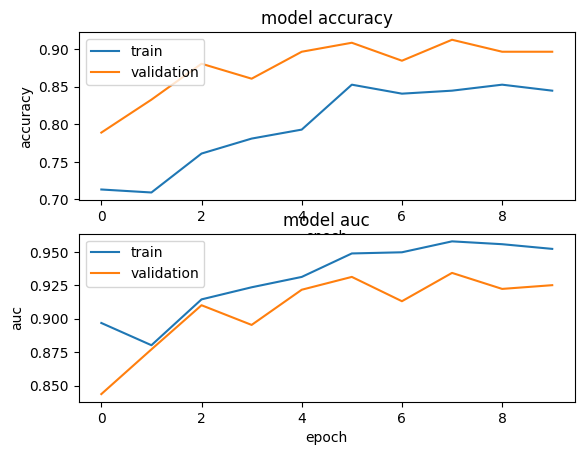

In [11]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc'])
ax2.plot(history.history['val_auc'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()

In [12]:
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = validation_iterator.classes
class_labels = list(validation_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

8/8 [==============================] - 1s 90ms/step
              precision    recall  f1-score   support

       Covid       0.47      0.50      0.49       111
      Normal       0.25      0.23      0.24        70
   Pneumonia       0.31      0.30      0.31        70

    accuracy                           0.37       251
   macro avg       0.34      0.34      0.34       251
weighted avg       0.36      0.37      0.37       251



In [13]:
cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

[[56 32 23]
 [31 16 23]
 [32 17 21]]


In [18]:
# 1) Load the SnakeViz IPython extension
%load_ext snakeviz

import math

# 2) Define your inference routine exactly as before
def run_inference():
    steps = math.ceil(validation_iterator.samples / validation_iterator.batch_size)
    _ = model.predict(validation_iterator, steps=steps)

# 3) Fire up SnakeViz on that function — this will start the server
#    and open your default browser to the flame-graph UI
%snakeviz run_inference()


The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz
8/8 [==============================] - 1s 129ms/step
 
*** Profile stats marshalled to file 'C:\\Users\\alaso\\AppData\\Local\\Temp\\tmpwst5pbyp'.
Embedding SnakeViz in this document...
<function display at 0x000002637B0825C0>


In [19]:
import cProfile, math, subprocess, time, webbrowser

# 1) Profile and dump to a .prof file
profiler = cProfile.Profile()
profiler.enable()
run_inference()
profiler.disable()
profiler.dump_stats("inference.prof")

# 2) Launch SnakeViz as a standalone server on a known port
port = 5555
subprocess.Popen([
    "python", "-m", "snakeviz", "inference.prof",
    "--port", str(port)
])

# 3) Give it a moment to start up
time.sleep(2)

# 4) Open a new Chrome tab to the SnakeViz UI
url = f"http://127.0.0.1:{port}/"
# On Windows, 'start' will invoke the default browser; adjust if Chrome is your default
subprocess.Popen(['start', url], shell=True)

print(f"SnakeViz should now be running at {url}")


8/8 [==============================] - 1s 91ms/step
SnakeViz should now be running at http://127.0.0.1:5555/


In [27]:
!jupyter nbconvert --to script classification-challenge-sol.ipynb



[NbConvertApp] Converting notebook classification-challenge-sol.ipynb to script
[NbConvertApp] Writing 6258 bytes to classification-challenge-sol.py


In [26]:
!pip install nbconvert

                                              0.0/258.5 kB ? eta -:--:--
     ------------------------------------  256.0/258.5 kB 16.4 MB/s eta 0:00:01
     -------------------------------------- 258.5/258.5 kB 8.0 MB/s eta 0:00:00
                                              0.0/163.4 kB ? eta -:--:--
     -------------------------------------- 163.4/163.4 kB 9.6 MB/s eta 0:00:00
                                              0.0/53.4 kB ? eta -:--:--
     ---------------------------------------- 53.4/53.4 kB ? eta 0:00:00
                                              0.0/78.5 kB ? eta -:--:--
     ---------------------------------------- 78.5/78.5 kB ? eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
